# EAD ALAMENDA

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

In [3]:
import sys
sys.path.insert(0, '/Users/mrahimi/AVM/module/')
import Plot
pl = Plot.Plot()

In [4]:
path = ""
print("Read train file to obtain some statistic about the features and target")
df = pd.read_csv(path + 'alameda.csv', parse_dates=['INACT_SELLING_DATE'])

Read train file to obtain some statistic about the features and target


In [5]:
print("the shape of the data frame")
print(df.shape)

the shape of the data frame
(10587, 38)


In [6]:
df.loc[df.LONGITUDE == 0.0, ["LONGITUDE"]] = np.nan
df.loc[df.LATITUDE == 0.0, ["LATITUDE"]] = np.nan

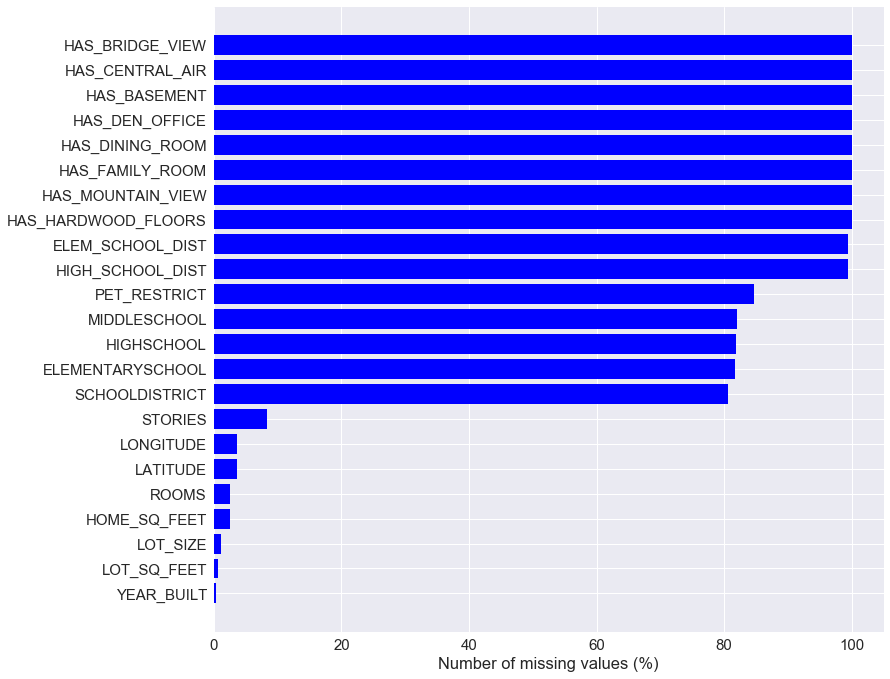

In [7]:
pl.missing(df)

In [8]:
# drop features with more than 90% missing value
df = df.drop(['HAS_BRIDGE_VIEW', 'HAS_MOUNTAIN_VIEW', 'HAS_BASEMENT', 
              'HAS_DEN_OFFICE', 'HAS_DINING_ROOM', 'HAS_FAMILY_ROOM',
              'HAS_CENTRAL_AIR', 'HAS_HARDWOOD_FLOORS',
              'ELEM_SCHOOL_DIST', 'HIGH_SCHOOL_DIST'
              ], axis = 1)

In [9]:
for ii in df.columns:
    print(ii, df[ii].unique().size)
#df.CITY.unique().size

LISTING_NUM 10587
ADDRESS 10227
CITY 19
ZIP 63
LATITUDE 9480
LONGITUDE 9375
HAS_GARAGE 1
HAS_CARPORT 1
PET_RESTRICT 19
BEDROOMS 9
FULL_BATHS 8
PARTIAL_BATHS 6
YEAR_BUILT 138
STORIES 4
ROOMS 24
HOME_SQ_FEET 2690
LOT_SIZE 4279
LOT_SQ_FEET 4315
INACT_SELLING_DATE 506
LISTING_AGENT 4041
LISTING_OFFICE 1410
SCHOOLDISTRICT 24
ELEMENTARYSCHOOL 153
MIDDLESCHOOL 54
HIGHSCHOOL 39
NUM_IMAGES 55
LISTING_PRICE 1842
INACT_SELLING_PRICE 1889


1. there are 10584-10224=360 duplications in Address
2. features HAS_GARAGE and HAS_CARPORT contain only one unique value and they can drop from dataset.

In [10]:
df = df.drop(['HAS_GARAGE', 'HAS_CARPORT'], axis=1)
print("shape of the data", df.shape)

shape of the data (10587, 26)


In [11]:
# drop missing lat and long
index = ~df["LATITUDE"].isnull() & ~df["LONGITUDE"].isnull()
df = df[index]
df.shape

(10200, 26)

In [12]:
# I assume the HOME_SQ_FEET is a nessacery feature and I droped all missing value
index = ~df["HOME_SQ_FEET"].isnull()
df = df[index]
df.shape

(9956, 26)

## duplication
lets look at the number of duplication

In [13]:
print(df['ADDRESS'].duplicated().sum())
print(df[['ADDRESS', 'INACT_SELLING_PRICE']].duplicated().sum())
print(df[['ADDRESS', 'INACT_SELLING_PRICE', 'INACT_SELLING_DATE']].duplicated().sum())

158
53
44


At this point, I drop all ADDRESS duplications. I will come back and look at them more carefuly.

In [14]:
import copy
df2 = copy.deepcopy(df.drop_duplicates(['ADDRESS']))
print(df2.shape)

(9798, 26)


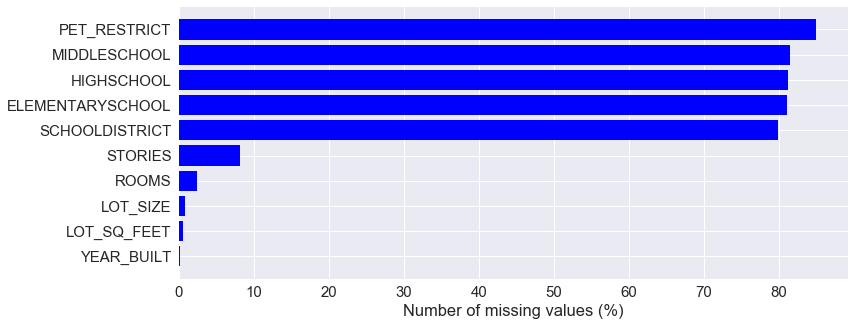

In [15]:
pl.missing(df2)

## Object features

In [16]:
obj = []
for f, c in zip(df2.columns, df2.dtypes):
    if c == "object":
        obj.append(f)
        print(f, df2[f].unique().size)

ADDRESS 9798
CITY 19
PET_RESTRICT 18
LOT_SIZE 4055
LISTING_AGENT 3800
LISTING_OFFICE 1317
SCHOOLDISTRICT 23
ELEMENTARYSCHOOL 148
MIDDLESCHOOL 51
HIGHSCHOOL 35


In [17]:
# I drop the Address and LISTING_NUM since they are unique for each property
# I drop the Agent information; I think the value should not depend on the Agent
df2 = df2.drop(['ADDRESS', 'LISTING_NUM', 'LISTING_OFFICE', 'LISTING_AGENT'], axis = 1)

In [18]:
# Pet_Restrict
print("NULL",sum(df2["PET_RESTRICT"].isnull()) / df2.shape[0])
# I consider three possibilities
# 1 = NaN, 2 = 'No Dogs or Cats', 3 = 'Pets Allowed'
index1 = df2["PET_RESTRICT"].isnull()
index2 = df2["PET_RESTRICT"] == 'No Dogs or Cats'

df2.loc[index1, "PET_RESTRICT"] = 1
df2.loc[index2, "PET_RESTRICT"] = 2

df2.loc[~index1 & ~index2, "PET_RESTRICT"] = 3

NULL 0.849867319861


In [19]:
obj = []
for f, c in zip(df2.columns, df2.dtypes):
    if c == "object":
        obj.append(f)
        print(f, df2[f].unique().size)

CITY 19
PET_RESTRICT 3
LOT_SIZE 4055
SCHOOLDISTRICT 23
ELEMENTARYSCHOOL 148
MIDDLESCHOOL 51
HIGHSCHOOL 35


In [20]:
# convert object features to int
from sklearn.preprocessing import LabelEncoder
print("convert object features to int")
for c in obj:
    df2[c] = df2[c].fillna(-2)
    lbl = LabelEncoder()
    lbl.fit(list(df2[c].values))
    df2[c] = lbl.transform(list(df2[c].values))

convert object features to int


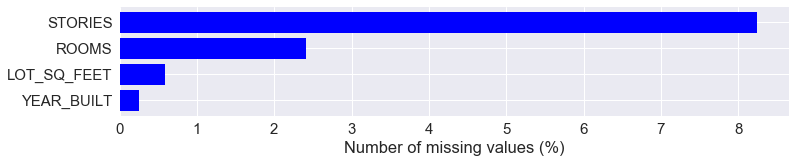

In [22]:
pl.missing(df2)

In [23]:
# STORIES AND ROOMS NEEDS to convert to int but they have missing value :( I first should impute missing value
# At this point I keep the types as float but I have to think about it later
df2.dtypes

CITY                            int64
ZIP                             int64
LATITUDE                      float64
LONGITUDE                     float64
PET_RESTRICT                    int64
BEDROOMS                        int64
FULL_BATHS                      int64
PARTIAL_BATHS                   int64
YEAR_BUILT                    float64
STORIES                       float64
ROOMS                         float64
HOME_SQ_FEET                  float64
LOT_SIZE                        int64
LOT_SQ_FEET                   float64
INACT_SELLING_DATE     datetime64[ns]
SCHOOLDISTRICT                  int64
ELEMENTARYSCHOOL                int64
MIDDLESCHOOL                    int64
HIGHSCHOOL                      int64
NUM_IMAGES                      int64
LISTING_PRICE                   int64
INACT_SELLING_PRICE             int64
dtype: object

In [24]:
# Create Target 
df2["log_price"] = np.log(df2.INACT_SELLING_PRICE)

## Error of selling price and listing price
I spilit the data to test and train. I want to know the mean value of the home price in the test dataset and error of the listing price

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df2, df2.INACT_SELLING_PRICE, test_size=0.25, random_state=42)

print("train size: ", X_train.shape)
print("test size: ", X_test.shape)

train size:  (7348, 23)
test size:  (2450, 23)


In [26]:
y_test.describe()

count    2.450000e+03
mean     8.760577e+05
std      4.145799e+05
min      1.495000e+05
25%      6.200000e+05
50%      7.810000e+05
75%      1.030000e+06
max      4.500000e+06
Name: INACT_SELLING_PRICE, dtype: float64

In [27]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, X_test.LISTING_PRICE)

62867.519183673467

the mean value of the price in the test data set is 8.75e5 and error is 0.68e5

In [28]:
X_test["log_price"].describe()

count    2450.000000
mean       13.592183
std         0.419339
min        11.915052
25%        13.337475
50%        13.568330
75%        13.845069
max        15.319588
Name: log_price, dtype: float64

In [29]:
mean_absolute_error(np.log(y_test), np.log(X_test.LISTING_PRICE))

0.072151521099909771

the mean value of the log_price in the test dataset is 13.58 and error is 0.078

# XGBOOST

In [30]:
import xgb

In [31]:
import copy
X = copy.deepcopy(df2.drop(['log_price', 'INACT_SELLING_DATE', 'LISTING_PRICE', 'INACT_SELLING_PRICE'], axis = 1))
Y = copy.deepcopy(df2.log_price)

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

print("train size: ", X_train.shape)
print("test size: ", X_test.shape)

train size:  (7348, 19)
test size:  (2450, 19)


In [33]:
X_train.columns

Index(['CITY', 'ZIP', 'LATITUDE', 'LONGITUDE', 'PET_RESTRICT', 'BEDROOMS',
       'FULL_BATHS', 'PARTIAL_BATHS', 'YEAR_BUILT', 'STORIES', 'ROOMS',
       'HOME_SQ_FEET', 'LOT_SIZE', 'LOT_SQ_FEET', 'SCHOOLDISTRICT',
       'ELEMENTARYSCHOOL', 'MIDDLESCHOOL', 'HIGHSCHOOL', 'NUM_IMAGES'],
      dtype='object')

In [34]:
opt = xgb.XGBoostOpt(eval_metric = 'mae')
opt.make_grid(eta = [0.04, 0.05, 0.06], max_depth = [6, 7, 8])

{'eval_metric': 'mae', 'objective': 'reg:linear', 'silent': True}
{'eta': [0.04, 0.05, 0.06], 'max_depth': [6, 7, 8]}
[[0.04, 6], [0.04, 7], [0.04, 8], [0.05, 6], [0.05, 7], [0.05, 8], [0.06, 6], [0.06, 7], [0.06, 8]]


In [35]:
opt.optimization(X_train, y_train, X_test, y_test, num_boost_round = 2000, early_stopping = 5)

{'eta': 0.04, 'max_depth': 6}
{'eta': 0.04, 'max_depth': 7}
{'eta': 0.04, 'max_depth': 8}
{'eta': 0.05, 'max_depth': 6}
{'eta': 0.05, 'max_depth': 7}
{'eta': 0.05, 'max_depth': 8}
{'eta': 0.06, 'max_depth': 6}
{'eta': 0.06, 'max_depth': 7}
{'eta': 0.06, 'max_depth': 8}


In [36]:
opt.scores()

,eta,max_depth,iterations,score
0,0.06,8,342,0.087890
0,0.04,7,415,0.087899
0,0.05,8,269,0.088135
0,0.05,7,302,0.088323
0,0.04,6,468,0.088681
0,0.05,6,371,0.088755
0,0.04,8,234,0.089065
0,0.06,7,213,0.089361
0,0.06,6,229,0.090025


In [37]:
model = xgb.XGBoostReg(eval_metric = 'mae', eta = 0.04, max_depth = 8)
model.fit_eval(X_train, y_train, 
               X_test, y_test, 
               num_boost_round = 2000, early_stopping = 5)

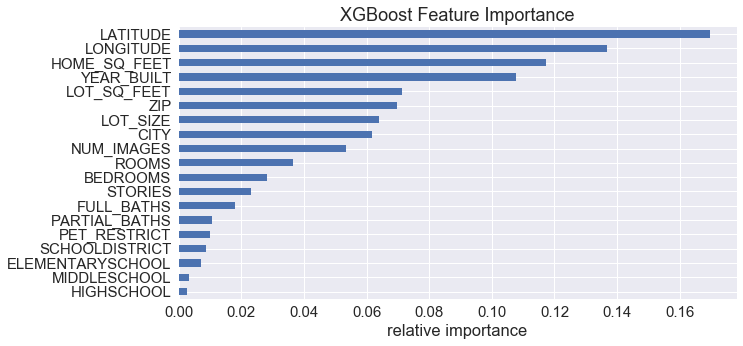

In [38]:
model.plot_importance(N=19)

## New Features

In [41]:
from sklearn.neighbors import KNeighborsRegressor

k = 15
model = KNeighborsRegressor(n_neighbors=k)
model.fit(X[['LATITUDE', 'LONGITUDE']], Y)

X["knn_price"] = (k * model.predict(X[['LATITUDE', 'LONGITUDE']]) - Y) / (k-1)

In [42]:
k = 15
Z = np.log(np.exp(df2.log_price) / df2.HOME_SQ_FEET)

model = KNeighborsRegressor(n_neighbors=k)
model.fit(X[['LATITUDE', 'LONGITUDE']], Z)

X["knn_price2"] = (k * model.predict(X[['LATITUDE', 'LONGITUDE']]) - Z) / (k-1)

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

print("train size: ", X_train.shape)
print("test size: ", X_test.shape)

train size:  (7348, 21)
test size:  (2450, 21)


In [47]:
opt = xgb.XGBoostOpt(eval_metric = 'mae')
opt.make_grid(eta = [0.06, 0.07, 0.08, 0.09, 0.1], max_depth = [8, 9, 10])

{'eval_metric': 'mae', 'objective': 'reg:linear', 'silent': True}
{'eta': [0.06, 0.07, 0.08, 0.09, 0.1], 'max_depth': [8, 9, 10]}
[[0.06, 8], [0.06, 9], [0.06, 10], [0.07, 8], [0.07, 9], [0.07, 10], [0.08, 8], [0.08, 9], [0.08, 10], [0.09, 8], [0.09, 9], [0.09, 10], [0.1, 8], [0.1, 9], [0.1, 10]]


In [48]:
opt.optimization(X_train, y_train, X_test, y_test, num_boost_round = 2000, early_stopping = 5)

{'eta': 0.06, 'max_depth': 8}
{'eta': 0.06, 'max_depth': 9}
{'eta': 0.06, 'max_depth': 10}
{'eta': 0.07, 'max_depth': 8}
{'eta': 0.07, 'max_depth': 9}
{'eta': 0.07, 'max_depth': 10}
{'eta': 0.08, 'max_depth': 8}
{'eta': 0.08, 'max_depth': 9}
{'eta': 0.08, 'max_depth': 10}
{'eta': 0.09, 'max_depth': 8}
{'eta': 0.09, 'max_depth': 9}
{'eta': 0.09, 'max_depth': 10}
{'eta': 0.1, 'max_depth': 8}
{'eta': 0.1, 'max_depth': 9}
{'eta': 0.1, 'max_depth': 10}


In [49]:
opt.scores()

,eta,max_depth,iterations,score
0,0.07,9,135,0.085506
0,0.07,10,169,0.085747
0,0.08,8,158,0.085812
0,0.06,10,184,0.085868
0,0.10,9,133,0.085899
0,0.09,10,109,0.085947
0,0.07,8,157,0.085971
0,0.08,10,143,0.085976
0,0.10,8,115,0.086083
0,0.09,9,135,0.086154


In [50]:
model = xgb.XGBoostReg(eval_metric = 'mae', eta = 0.07, max_depth = 9)
model.fit_eval(X_train, y_train, 
               X_test, y_test, 
               num_boost_round = 2000, early_stopping = 5)

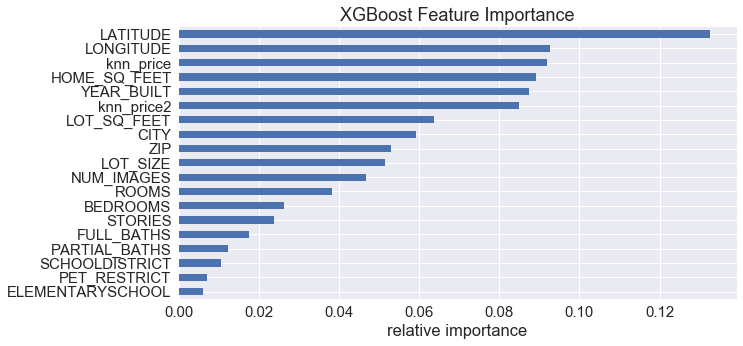

In [51]:
model.plot_importance(N=19)

In [52]:
pred = model.predict(X_test)

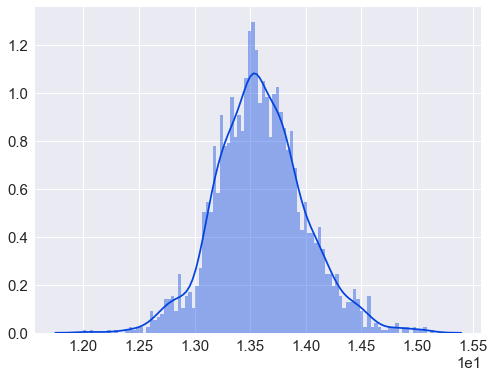

In [53]:
pl.distro(pred)

Text(0.5,1,'Actual log_price')

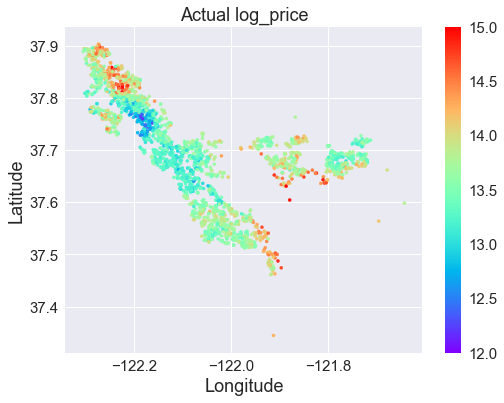

In [56]:
cmap = plt.get_cmap('rainbow')

f, ax = plt.subplots(figsize=(8,6))
points = ax.scatter(X_test["LONGITUDE"].values, X_test["LATITUDE"].values, c=y_test, vmin=12., vmax=15., s=10, cmap=cmap)
f.colorbar(points)

plt.xlabel('Longitude', fontsize=18)
plt.ylabel('Latitude', fontsize=18)
plt.title('Actual log_price')

Text(0.5,1,'predicted log_price')

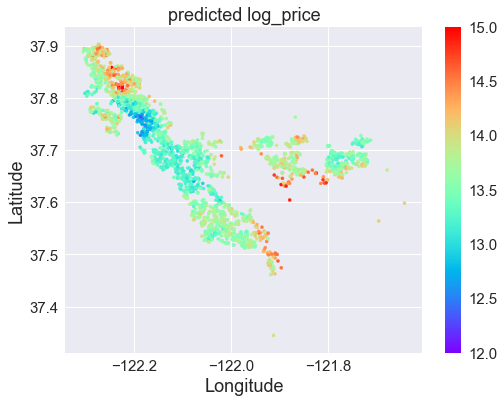

In [55]:
cmap = plt.get_cmap('rainbow')

f, ax = plt.subplots(figsize=(8,6))
points = ax.scatter(X_test["LONGITUDE"].values, X_test["LATITUDE"].values, c=pred, vmin=12., vmax=15., s=10, cmap=cmap)
f.colorbar(points)

plt.xlabel('Longitude', fontsize=18)
plt.ylabel('Latitude', fontsize=18)
plt.title('predicted log_price')

## Test
I want to test the performance without calculating knn for all data

In [99]:
import copy
X = copy.deepcopy(df2.drop(['log_price', 'INACT_SELLING_DATE', 'LISTING_PRICE', 'INACT_SELLING_PRICE'], axis = 1))
Y = copy.deepcopy(df2.log_price)

In [100]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = copy.deepcopy(train_test_split(X, Y, test_size=0.25, random_state=42))

print("train size: ", X_train.shape)
print("test size: ", X_test.shape)

train size:  (7348, 19)
test size:  (2450, 19)


In [101]:
k = 15
model = KNeighborsRegressor(n_neighbors=k)
model.fit(X_train[['LATITUDE', 'LONGITUDE']], y_train)

X_train["knn_price"] = (k * model.predict(X_train[['LATITUDE', 'LONGITUDE']]) - y_train) / (k-1)
X_test["knn_price"] = model.predict(X_test[['LATITUDE', 'LONGITUDE']])

In [102]:
k = 15
norm_price = np.log(np.exp(y_train) / X_train.HOME_SQ_FEET)

model = KNeighborsRegressor(n_neighbors=k)
model.fit(X_train[['LATITUDE', 'LONGITUDE']], norm_price)

X_train["knn_price2"] = (k * model.predict(X_train[['LATITUDE', 'LONGITUDE']]) - norm_price) / (k-1)
X_test["knn_price2"] = model.predict(X_test[['LATITUDE', 'LONGITUDE']])

In [103]:
print("train size: ", X_train.shape)
print("test size: ", X_test.shape)

train size:  (7348, 21)
test size:  (2450, 21)


In [104]:
opt = xgb.XGBoostOpt(eval_metric = 'mae')
opt.make_grid(eta = [0.06, 0.07, 0.08, 0.09, 0.1], max_depth = [8, 9, 10])

{'eval_metric': 'mae', 'objective': 'reg:linear', 'silent': True}
{'eta': [0.06, 0.07, 0.08, 0.09, 0.1], 'max_depth': [8, 9, 10]}
[[0.06, 8], [0.06, 9], [0.06, 10], [0.07, 8], [0.07, 9], [0.07, 10], [0.08, 8], [0.08, 9], [0.08, 10], [0.09, 8], [0.09, 9], [0.09, 10], [0.1, 8], [0.1, 9], [0.1, 10]]


In [105]:
opt.optimization(X_train, y_train, X_test, y_test, num_boost_round = 2000, early_stopping = 5)

{'eta': 0.06, 'max_depth': 8}
{'eta': 0.06, 'max_depth': 9}
{'eta': 0.06, 'max_depth': 10}
{'eta': 0.07, 'max_depth': 8}
{'eta': 0.07, 'max_depth': 9}
{'eta': 0.07, 'max_depth': 10}
{'eta': 0.08, 'max_depth': 8}
{'eta': 0.08, 'max_depth': 9}
{'eta': 0.08, 'max_depth': 10}
{'eta': 0.09, 'max_depth': 8}
{'eta': 0.09, 'max_depth': 9}
{'eta': 0.09, 'max_depth': 10}
{'eta': 0.1, 'max_depth': 8}
{'eta': 0.1, 'max_depth': 9}
{'eta': 0.1, 'max_depth': 10}


In [106]:
opt.scores()

,eta,max_depth,iterations,score
0,0.09,9,158,0.084376
0,0.08,8,184,0.084399
0,0.06,10,179,0.084410
0,0.08,10,128,0.084520
0,0.08,9,136,0.084615
0,0.07,10,163,0.084678
0,0.09,10,123,0.084737
0,0.07,8,153,0.084739
0,0.07,9,136,0.084942
0,0.09,8,160,0.084978


In [113]:
model = xgb.XGBoostReg(eval_metric = 'mae', eta = 0.09, max_depth = 9)
model.fit_eval(X_train, y_train, 
               X_test, y_test, 
               num_boost_round = 2000, early_stopping = 5)

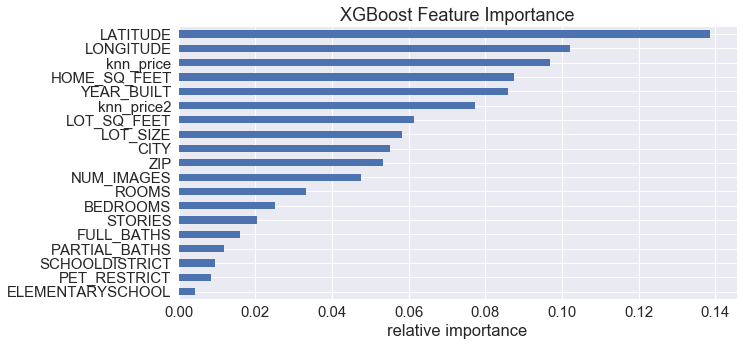

In [114]:
model.plot_importance(N=19)

In [115]:
pred = model.predict(X_test)

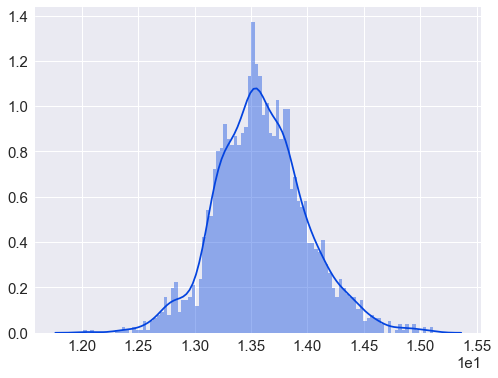

In [116]:
pl.distro(pred)

Text(0.5,1,'Actual log_price')

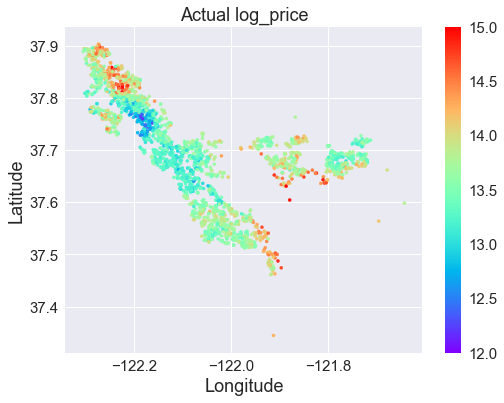

In [117]:
cmap = plt.get_cmap('rainbow')

f, ax = plt.subplots(figsize=(8,6))
points = ax.scatter(X_test["LONGITUDE"].values, X_test["LATITUDE"].values, c=y_test, vmin=12., vmax=15., s=10, cmap=cmap)
f.colorbar(points)

plt.xlabel('Longitude', fontsize=18)
plt.ylabel('Latitude', fontsize=18)
plt.title('Actual log_price')

Text(0.5,1,'predicted log_price')

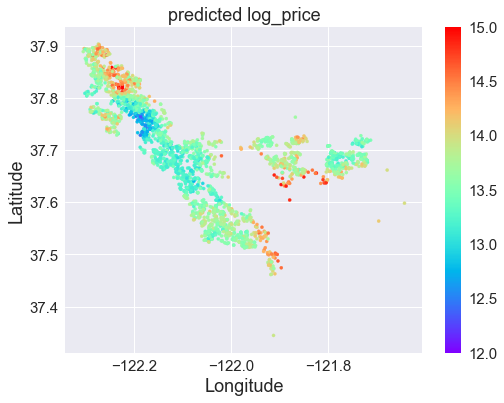

In [118]:
cmap = plt.get_cmap('rainbow')

f, ax = plt.subplots(figsize=(8,6))
points = ax.scatter(X_test["LONGITUDE"].values, X_test["LATITUDE"].values, c=pred, vmin=12., vmax=15., s=10, cmap=cmap)
f.colorbar(points)

plt.xlabel('Longitude', fontsize=18)
plt.ylabel('Latitude', fontsize=18)
plt.title('predicted log_price')